In [ ]:
pip install ta


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29088 sha256=9033097a7f4129093c3ae4f0a97862db37d1220fbad1bacf3c6626c39aa7de2b
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
Successfully built ta


In [ ]:
pip install dash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 2.3.6
    Uninstalling Werkzeug-2.3.6:
      Successfully uninstalled Werkzeug-2.3.6


In [ ]:
pip install plotly

In [ ]:
import yfinance as yf #getting data
import pandas as pd #data handling
import numpy as np #calc
import ta #tech indi
import matplotlib.pyplot as plt #visualization
from dash import Dash,Input, Output, dcc, html,callback, dash_table


In [ ]:
df=yf.download('AAPL',start='2019-01-01')

[*********************100%***********************]  1 of 1 completed


In [ ]:
df['ma_20']=df.Close.rolling(20).mean()
df['vol']=df.Close.rolling(20).std()
df['upper_bb']=df.ma_20+(2*df.vol)
df['lower_bb']=df.ma_20-(2*df.vol)


In [ ]:
df.reset_index(inplace=True)


In [ ]:
df.columns


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'ma_20',
       'vol', 'upper_bb', 'lower_bb'],
      dtype='object')

In [ ]:
df.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume,ma_20,vol,upper_bb,lower_bb
1150,2023-07-28,194.669998,196.630005,194.139999,195.830002,195.830002,48291400,192.287501,2.099920,196.487341,188.087660
1151,2023-07-31,196.059998,196.490005,195.259995,196.449997,196.449997,38824100,192.411501,2.270772,196.953044,187.869957
1152,2023-08-01,196.240005,196.729996,195.279999,195.610001,195.610001,35175100,192.569000,2.380884,197.330769,187.807231
1153,2023-08-02,195.039993,195.179993,191.850006,192.580002,192.580002,50389300,192.631500,2.362987,197.357475,187.905525
1154,2023-08-03,191.570007,192.369995,190.690002,191.169998,191.169998,61235200,192.599500,2.378977,197.357455,187.841546
1155,2023-08-04,185.520004,187.380005,181.919998,181.990005,181.990005,115799700,192.165001,3.345320,198.855642,185.474360
1156,2023-08-07,182.130005,183.130005,177.350006,178.850006,178.850006,97576100,191.677001,4.427904,200.532810,182.821193
1157,2023-08-08,179.690002,180.270004,177.580002,179.800003,179.800003,67823000,191.263001,5.115596,201.494193,181.031809
1158,2023-08-09,180.869995,180.929993,177.009995,178.190002,178.190002,60378500,190.684001,5.890164,202.464329,178.903673
1159,2023-08-10,179.479996,180.750000,177.600998,177.970001,177.970001,51330160,190.055502,6.541010,203.137521,176.973482


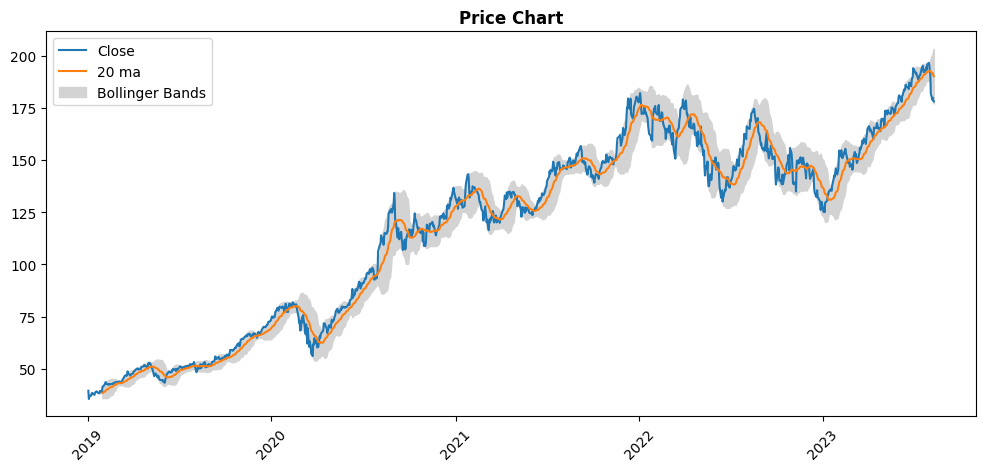

In [ ]:
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

x_axis = df['Date']

plt.plot(x_axis, df['Close'], label = 'Close')
plt.plot(df['Date'], df['ma_20'], label = '20 ma')
plt.fill_between(x_axis, df['upper_bb'], df['lower_bb'], label = 'Bollinger Bands', color='lightgrey')

plt.title('Price Chart', fontweight="bold")
plt.legend()
plt.show()

Calculating
Relative Strength Index (RSI) measures the magnitude of recent price changes and evaluates if a stock has been overbought or oversold.


In [ ]:
def gain(value):
    if value < 0:
        return 0
    else:
        return value

In [ ]:
def loss(value):
    if value > 0:
        return 0
    else:
        return abs(value)

In [ ]:
period = 6

#Calculate price delta
df['delta'] = df['Close'].diff()

#Classify delta into gain & loss
df['gain'] = df['delta'].apply(lambda x:gain(x))
df['loss'] = df['delta'].apply(lambda x:loss(x))

#Calculate ema
df['ema_gain'] = df['gain'].ewm(period).mean()
df['ema_loss'] = df['loss'].ewm(period).mean()

#Calculate RSI
df['rs'] = df['ema_gain']/df['ema_loss']
df['rsi'] = df['rs'].apply(lambda x: 100 - (100/(x+1)))

or use direct technical indicator library to find rsi

In [ ]:
df['rsi_direct']=ta.momentum.rsi(df.Close,window=6)

(0.0, 100.0)

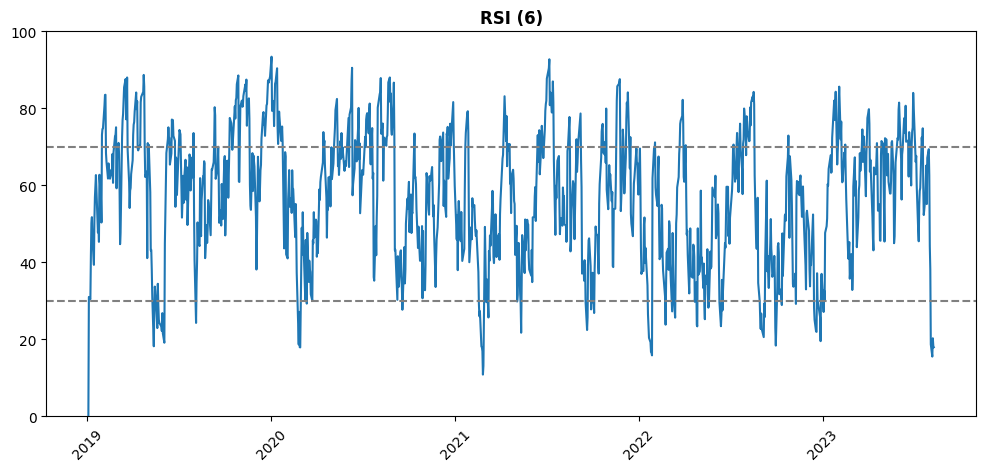

In [ ]:
#plot for validation
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

x_axis = df['Date']

plt.plot(x_axis, df['rsi'])
plt.axhline(30, c= (.5,.5,.5), ls='--')
plt.axhline(70, c= (.5,.5,.5), ls='--')

plt.title('RSI (6)', fontweight="bold")
plt.ylim([0, 100])

##Implementing buy/sell




1. Buy when 10-period RSI below 30 (buy next day) & Price below lower bollinger band
2. Sell when 10-period RSI above 70 (sell next day) & Price above upper bollinger band


In [ ]:
#buy signal
df['signal'] = np.where(
    (df['rsi'] < 30) &
    (df['Close'] < df['lower_bb']), 1, np.nan)

#sell signal
df['signal'] = np.where(
    (df['rsi'] > 70) &
    (df['Close'] > df['upper_bb']), -1, df['signal'])

#buy/sell next trading day
df['signal'] = df['signal'].shift()
df['signal'] = df['signal'].fillna(0)

In [ ]:
#buy signal
df['signal'] = np.where(
    (df['rsi'] < 30) &
    (df['Close'] < df['lower_bb']), 1, np.nan)

#sell signal
df['signal'] = np.where(
    (df['rsi'] > 70) &
    (df['Close'] > df['upper_bb']), -1, df['signal'])

#buy/sell next trading day
df['signal'] = df['signal'].shift()
df['signal'] = df['signal'].fillna(0)

In [ ]:
print(df)

           Date        Open        High         Low       Close   Adj Close  \
0    2019-01-02   38.722500   39.712502   38.557499   39.480000   37.994495   
1    2019-01-03   35.994999   36.430000   35.500000   35.547501   34.209957   
2    2019-01-04   36.132500   37.137501   35.950001   37.064999   35.670357   
3    2019-01-07   37.174999   37.207500   36.474998   36.982498   35.590973   
4    2019-01-08   37.389999   37.955002   37.130001   37.687500   36.269436   
...         ...         ...         ...         ...         ...         ...   
1155 2023-08-04  185.520004  187.380005  181.919998  181.990005  181.990005   
1156 2023-08-07  182.130005  183.130005  177.350006  178.850006  178.850006   
1157 2023-08-08  179.690002  180.270004  177.580002  179.800003  179.800003   
1158 2023-08-09  180.869995  180.929993  177.009995  178.190002  178.190002   
1159 2023-08-10  179.479996  180.750000  177.600998  177.970001  177.970001   

         Volume       ma_20       vol    upper_bb  

In [ ]:
import pandas as pd
import numpy as np


def backtest_dataframe(df):
    position = 0
    net_profit = 0
    percentage_change = []
    df['buy_date'] = ''
    df['sell_date'] = ''

    for i in df.index:
        close = df["Close"][i]
        date = df['Date'][i]

        # Buy action
        if df["signal"][i] == 1:
            if(position == 0):
                buy_price = close
                position = 1
                df.at[i, 'buy_date'] = date
                print(f"Buying at {str(buy_price)} on {str(date)}")

        # Sell action
        elif (df["signal"][i] == -1):
            if(position == 1):
                sell_price = close
                bought = 0
                position = 0
                df.at[i, 'sell_date'] = date
                print(f"Selling at {str(sell_price)} on {str(date)}")

                # Get percentage change of trade
                pc = (sell_price/buy_price-1)*100
                percentage_change.append(pc)
                net_profit += (sell_price - buy_price)

    # Calculate trade statistics
    gains = 0
    ng = 0
    losses = 0
    nl = 0
    totalR = 1

    for i in percentage_change:
        if(i > 0):
            gains += i
            ng += 1
        else:
            losses += i
            nl += 1
        totalR = totalR * ((i/100)+1)

    totalR = round((totalR-1)*100, 2)

    if(ng > 0):
        avgGain = round(gains/ng, 2)
        maxR = round(max(percentage_change), 2)
    else:
        avgGain = 0
        maxR = "undefined"

    if(nl > 0):
        avgLoss = round(losses/nl, 2)
        maxL = round(min(percentage_change), 2)
    else:
        avgLoss = 0
        maxL = "undefined"

    if(ng > 0 or nl > 0):
        win_rate = round((ng/(ng+nl))*100, 2)
    else:
        win_rate = 0

    Metric=['Number of Trades','Number of Gains','Number of Losses','Total Returns %','Win Rate %','Average Gain %','Average Loss %','Max Return %','Max Loss %']
    Value=[ng+nl,ng,nl,totalR,win_rate,avgGain,avgLoss,maxR,maxL]
    results=pd.DataFrame({'Metric': Metric,
        'Value': Value})
    print()
    print('Evaluation Metrics:')
    print('-----------------------------------')
    print(f"Number of Trades: {ng+nl}")
    print(f"Number of Gains: {ng}")
    print(f"Number of Losses: {nl}")
    print(f"Total Returns: {totalR}%")
    print(f"Win Rate: {win_rate}%")
    print(f"Average Gain: {avgGain}%")
    print(f"Average Loss: {avgLoss}%")
    print(f"Max Return: {maxR}%")
    print(f"Max Loss: {maxL}%")
    print()
    return results

In [ ]:
print(df)

In [ ]:
a=backtest_dataframe(df)
print(a)

Buying at 47.165000915527344 on 2019-05-14 00:00:00
Selling at 52.10749816894531 on 2019-08-01 00:00:00
Buying at 49.25 on 2019-08-06 00:00:00
Selling at 55.772499084472656 on 2019-09-12 00:00:00
Buying at 72.0199966430664 on 2020-02-25 00:00:00
Selling at 71.10749816894531 on 2020-04-15 00:00:00
Buying at 125.86000061035156 on 2021-02-23 00:00:00
Selling at 130.36000061035156 on 2021-04-08 00:00:00
Buying at 128.10000610351562 on 2021-05-05 00:00:00
Selling at 129.63999938964844 on 2021-06-15 00:00:00
Buying at 143.42999267578125 on 2021-09-21 00:00:00
Selling at 149.25999450683594 on 2021-10-20 00:00:00
Buying at 164.50999450683594 on 2022-01-20 00:00:00
Selling at 174.72000122070312 on 2022-03-25 00:00:00
Buying at 156.57000732421875 on 2022-04-27 00:00:00
Selling at 154.08999633789062 on 2022-07-22 00:00:00
Buying at 157.22000122070312 on 2022-08-31 00:00:00
Selling at 149.35000610351562 on 2022-10-26 00:00:00
Buying at 134.50999450683594 on 2022-12-16 00:00:00
Selling at 142.52999

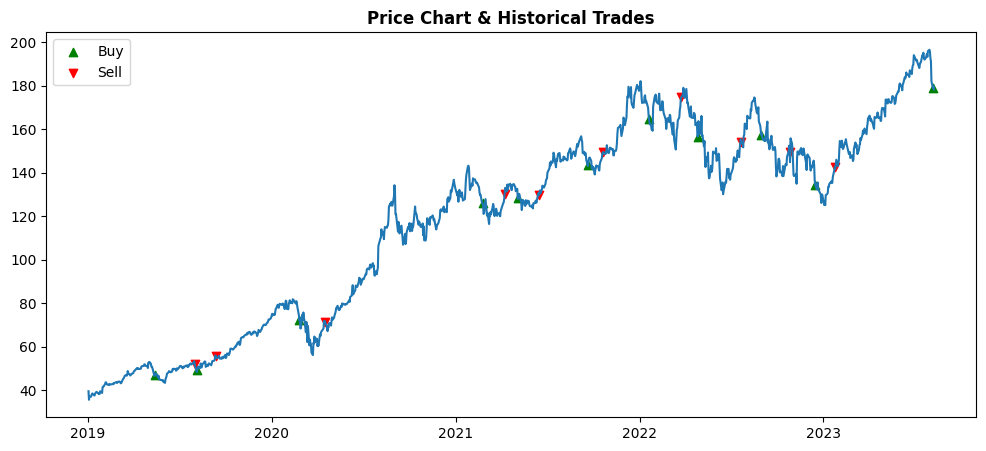

In [ ]:
plt.figure(figsize=(12,5))
# plt.xticks(rotation=45)

plt.plot(df['Date'], df['Close'])
plt.scatter(df[(df['signal'] == 1)]['buy_date'], df[(df['signal'] == 1)]['Close'], label = 'Buy', marker='^', c='g')
plt.scatter(df[(df['signal'] == -1)]['sell_date'], df[(df['signal'] == -1)]['Close'], label = 'Sell', marker='v', c='r')

plt.title('Price Chart & Historical Trades', fontweight="bold")
plt.legend()
plt.show()

In [ ]:
#implimenting stop losses

In [ ]:
conditions=[(df.rsi<30)&(df.Close<df.lower_bb),(df.rsi>70)&(df.Close>df.upper_bb)]
choices=['Buy','Sell']
df['signal']=np.select(conditions,choices)
df.dropna(inplace=True)
df.signal=df.signal.shift()

In [ ]:
#shifting signal logic/buyprice

In [ ]:
df['shifted_Close']=df.Close.shift()

In [ ]:
position=False
buydates,selldates=[],[]
buyprices,sellprices=[],[]

for index,row in df.iterrows():
  if not position and row['signal']=='Buy':
    buydates.append(index)
    buyprices.append(row.Open)
    position=True

  if position:
    if row['signal']=='Sell' or row.shifted_Close<0.95*buyprices[-1]:

      selldates.append(index)
      sellprices.append(row.Open)
      position=False

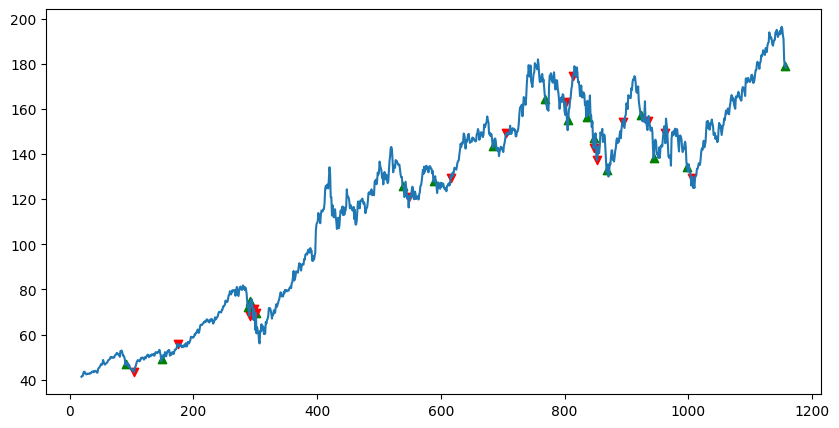

In [ ]:

plt.figure(figsize=(10,5))
plt.plot(df.Close)
plt.scatter(df.loc[buydates].index,df.loc[buydates].Close,marker='^',c='g')
plt.scatter(df.loc[selldates].index,df.loc[selldates].Close,marker='v',c='r')


In [ ]:
MR= round((pd.Series([(sell-buy)/buy for sell,buy in zip(sellprices,buyprices)])+1).prod(),2)
ML=round((pd.Series([(sell-buy)/buy for sell,buy in zip(sellprices,buyprices)])+1).prod()-1,2) #cumulatative return/losses

print(f"Max Return: {MR*100}%")
print(f"Max Loss: {ML*100}%")

Max Return: 97.0%
Max Loss: -3.0%


In [ ]:
app = Dash(__name__)

app.layout = html.Div([
	html.H1('Mean Reversion- Stock Screener'),

    html.Div(
        [
            html.Div([
                dcc.Dropdown(id="stock_name",options=["AAPL","SQ"]),
                html.Div([],id="table")]
                     )
        ]

)


           ] )



@callback(
    Output(component_id='table', component_property='children'),
    Input(component_id='stock_name', component_property='value')
)
def update_output_div(input_value):
    print(input_value)
    df=yf.download(input_value,start='2019-01-01')
    #df=backtest_dataframe(df)
    q=dash_table.DataTable(data=df.to_dict('records'), columns=[{"name": i, "id": i} for i in df.columns])
    return q

if __name__ == '__main__':
	app.run_server(debug=True,host='0.0.0.0',port=8058)


<IPython.core.display.Javascript object>